## SET UP

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from scipy.stats import boxcox
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
plt.style.use('bmh')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_Format', '{:,.2f}'.format)
np.set_printoptions(suppress=True)

## DATA UPLOAD

In [3]:
_path = 'MyPath_KPI.xlsx'
df = pd.read_excel(_path)

df.head()

,ORG_STATE,DISTRICT_ID,DISTRICT,DISTRICT_STATUS,SCHOOL_ID,SCHOOL,SCHOOL_STATUS,SITE_KEY,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,READING_GROWTH_SCHOOL,READING_GROWTH_DISTRICT,MATH_GROWTH_SCHOOL,MATH_GROWTH_DISTRICT
0,CO,3563706,JEFFCO PUBLIC SCHOOLS,Active,3096555,MCLAIN HS,Active,NaN,2022-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.01,0.01,-0.01,0.00
1,TX,3125780,San Benito Consolidated Independent School District,Active,3114960,Dr. C.M. Cash Elementary,Active,NaN,2022-23,NaN,NaN,164.00,90.00,18.00,12.00,0.00,0.00,13.00,9.00,5.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00
2,NY,3285141,North Rockland Central School District (NY),Active,3575856,Fieldstone Secondary School,Active,3614010,2023-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00
3,NC,3594219,Charlotte-Mecklenburg Schools,Active,3611057,Piney Grove Elementary School,Active,3702970,2023-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00
4,CA,3560893,New Haven Unified School District,Active,1010622,HILLVIEW CREST ELEMENTARY SCHOOL,Active,NaN,2021-22,4.00,25.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,5.00,383.00,118.00,81.71,"163,456.98",0.32,0.76,0.32,0.66,0.00,0.02,0.01,0.00


In [4]:
df.shape

(35071, 35)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35071 entries, 0 to 35070
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ORG_STATE                        34965 non-null  object 
 1   DISTRICT_ID                      35071 non-null  int64  
 2   DISTRICT                         35069 non-null  object 
 3   DISTRICT_STATUS                  35071 non-null  object 
 4   SCHOOL_ID                        35071 non-null  int64  
 5   SCHOOL                           35070 non-null  object 
 6   SCHOOL_STATUS                    33230 non-null  object 
 7   SITE_KEY                         3306 non-null   object 
 8   SCHOOL_YEAR                      35071 non-null  object 
 9   SCHOOL_ENROLLED_STUDENTS         9179 non-null   float64
 10  DISTRICT_ENROLLED_STUDENTS       9179 non-null   float64
 11  SCHOOL_LOGINS                    17692 non-null  float64
 12  DISTRICT_LOGINS   

In [6]:
org_index = df[['ORG_STATE', 'DISTRICT_ID', 'DISTRICT', 'DISTRICT_STATUS', 'SCHOOL_ID', 'SCHOOL', 'SITE_KEY']]

In [7]:
churn_metrics = df.iloc[:, 8:35]
churn_metrics.loc[:, 'is_churn'] = df['SCHOOL_STATUS']
churn_metrics.head()

,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,READING_GROWTH_SCHOOL,READING_GROWTH_DISTRICT,MATH_GROWTH_SCHOOL,MATH_GROWTH_DISTRICT,is_churn
0,2022-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.01,0.01,-0.01,0.00,Active
1,2022-23,NaN,NaN,164.00,90.00,18.00,12.00,0.00,0.00,13.00,9.00,5.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,Active
2,2023-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,Active
3,2023-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,Active
4,2021-22,4.00,25.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,5.00,383.00,118.00,81.71,"163,456.98",0.32,0.76,0.32,0.66,0.00,0.02,0.01,0.00,Active


In [8]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35071 entries, 0 to 35070
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      35071 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         9179 non-null   float64
 2   DISTRICT_ENROLLED_STUDENTS       9179 non-null   float64
 3   SCHOOL_LOGINS                    17692 non-null  float64
 4   DISTRICT_LOGINS                  17692 non-null  float64
 5   SCHOOL_UNI_LOGINS                17692 non-null  float64
 6   DISTRICT_UNI_LOGINS              17692 non-null  float64
 7   SCHOOL_UNI_STUDENT_LOGIN         17692 non-null  float64
 8   DISTRICT_UNI_STUDENT_LOGIN       17692 non-null  float64
 9   SCHOOL_UNI_EDUCATOR_LOGIN        17692 non-null  float64
 10  DISTRICT_UNI_EDUCATOR_LOGIN      17692 non-null  float64
 11  SCHOOL_UNI_ADMIN_LOGIN           17692 non-null  float64
 12  DISTRICT_UNI_ADMIN

In [9]:
churn_metrics.dropna(subset='is_churn', inplace=True)

In [10]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33230 entries, 0 to 35070
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      33230 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         8117 non-null   float64
 2   DISTRICT_ENROLLED_STUDENTS       8117 non-null   float64
 3   SCHOOL_LOGINS                    17692 non-null  float64
 4   DISTRICT_LOGINS                  17692 non-null  float64
 5   SCHOOL_UNI_LOGINS                17692 non-null  float64
 6   DISTRICT_UNI_LOGINS              17692 non-null  float64
 7   SCHOOL_UNI_STUDENT_LOGIN         17692 non-null  float64
 8   DISTRICT_UNI_STUDENT_LOGIN       17692 non-null  float64
 9   SCHOOL_UNI_EDUCATOR_LOGIN        17692 non-null  float64
 10  DISTRICT_UNI_EDUCATOR_LOGIN      17692 non-null  float64
 11  SCHOOL_UNI_ADMIN_LOGIN           17692 non-null  float64
 12  DISTRICT_UNI_ADMIN_LOGI

In [11]:
churn_metrics.fillna(0, inplace=True)

In [12]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33230 entries, 0 to 35070
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      33230 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         33230 non-null  float64
 2   DISTRICT_ENROLLED_STUDENTS       33230 non-null  float64
 3   SCHOOL_LOGINS                    33230 non-null  float64
 4   DISTRICT_LOGINS                  33230 non-null  float64
 5   SCHOOL_UNI_LOGINS                33230 non-null  float64
 6   DISTRICT_UNI_LOGINS              33230 non-null  float64
 7   SCHOOL_UNI_STUDENT_LOGIN         33230 non-null  float64
 8   DISTRICT_UNI_STUDENT_LOGIN       33230 non-null  float64
 9   SCHOOL_UNI_EDUCATOR_LOGIN        33230 non-null  float64
 10  DISTRICT_UNI_EDUCATOR_LOGIN      33230 non-null  float64
 11  SCHOOL_UNI_ADMIN_LOGIN           33230 non-null  float64
 12  DISTRICT_UNI_ADMIN_LOGI

In [13]:
churn_metrics = churn_metrics.astype({'SCHOOL_ENROLLED_STUDENTS':'int',
'DISTRICT_ENROLLED_STUDENTS':'int',
'SCHOOL_LOGINS':'int',
'DISTRICT_LOGINS':'int',
'SCHOOL_UNI_LOGINS':'int',
'DISTRICT_UNI_LOGINS':'int',
'SCHOOL_UNI_STUDENT_LOGIN':'int',
'DISTRICT_UNI_STUDENT_LOGIN':'int',
'SCHOOL_UNI_EDUCATOR_LOGIN':'int',
'DISTRICT_UNI_EDUCATOR_LOGIN':'int',
'SCHOOL_UNI_ADMIN_LOGIN':'int',
'DISTRICT_UNI_ADMIN_LOGIN':'int',
'SCHOOL_TOTAL_LESSONS':'int',
'SCHOOL_UNIQUE_LESSONS':'int',
'DISTRICT_TOTAL_LESSONS':'int',
'DISTRICT_UNIQUE_LESSONS':'int',
'SCHOOL_AVERAGE_MINUTES_SPENT':'int',
'DISTRICT_AVERAGE_MINUTES_SPENT':'int'})

In [14]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33230 entries, 0 to 35070
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      33230 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         33230 non-null  int64  
 2   DISTRICT_ENROLLED_STUDENTS       33230 non-null  int64  
 3   SCHOOL_LOGINS                    33230 non-null  int64  
 4   DISTRICT_LOGINS                  33230 non-null  int64  
 5   SCHOOL_UNI_LOGINS                33230 non-null  int64  
 6   DISTRICT_UNI_LOGINS              33230 non-null  int64  
 7   SCHOOL_UNI_STUDENT_LOGIN         33230 non-null  int64  
 8   DISTRICT_UNI_STUDENT_LOGIN       33230 non-null  int64  
 9   SCHOOL_UNI_EDUCATOR_LOGIN        33230 non-null  int64  
 10  DISTRICT_UNI_EDUCATOR_LOGIN      33230 non-null  int64  
 11  SCHOOL_UNI_ADMIN_LOGIN           33230 non-null  int64  
 12  DISTRICT_UNI_ADMIN_LOGI

In [15]:
churn_metrics.describe(include='all')

,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,READING_GROWTH_SCHOOL,READING_GROWTH_DISTRICT,MATH_GROWTH_SCHOOL,MATH_GROWTH_DISTRICT,is_churn
count,33230,"33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00",33230
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,2022-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active
freq,14497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32551
mean,NaN,15.37,15.32,226.72,226.71,16.91,16.90,12.73,12.71,3.78,3.77,0.44,0.41,337.73,33.02,337.10,32.93,"280,443.22","280,355.69",0.17,0.17,0.12,0.12,0.00,0.00,0.00,0.00,NaN
std,NaN,57.80,47.97,"1,008.86",619.66,61.81,40.11,59.33,37.24,6.58,5.43,1.11,0.87,"1,616.88",98.19,"1,299.76",89.33,"1,817,833.02","1,486,626.29",0.33,0.32,0.25,0.24,0.01,0.01,0.01,0.00,NaN
min,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.19,-0.08,-0.21,-0.07,NaN
25%,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
50%,NaN,0.00,0.00,1.00,3.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
75%,NaN,0.00,0.00,47.00,137.00,8.00,13.00,0.00,0.00,5.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN


In [16]:
churn_metrics['is_churn'] = churn_metrics['is_churn'].map({'Inactive': 1, 'Active': 0})

In [40]:
churn_metrics['is_churn'].sum()/churn_metrics.shape[0]

0.020433343364429733

In [17]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33230 entries, 0 to 35070
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      33230 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         33230 non-null  int64  
 2   DISTRICT_ENROLLED_STUDENTS       33230 non-null  int64  
 3   SCHOOL_LOGINS                    33230 non-null  int64  
 4   DISTRICT_LOGINS                  33230 non-null  int64  
 5   SCHOOL_UNI_LOGINS                33230 non-null  int64  
 6   DISTRICT_UNI_LOGINS              33230 non-null  int64  
 7   SCHOOL_UNI_STUDENT_LOGIN         33230 non-null  int64  
 8   DISTRICT_UNI_STUDENT_LOGIN       33230 non-null  int64  
 9   SCHOOL_UNI_EDUCATOR_LOGIN        33230 non-null  int64  
 10  DISTRICT_UNI_EDUCATOR_LOGIN      33230 non-null  int64  
 11  SCHOOL_UNI_ADMIN_LOGIN           33230 non-null  int64  
 12  DISTRICT_UNI_ADMIN_LOGI

In [18]:
churn_metrics.describe(include='all')

,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,READING_GROWTH_SCHOOL,READING_GROWTH_DISTRICT,MATH_GROWTH_SCHOOL,MATH_GROWTH_DISTRICT,is_churn
count,33230,"33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00","33,230.00"
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2022-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,14497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,15.37,15.32,226.72,226.71,16.91,16.90,12.73,12.71,3.78,3.77,0.44,0.41,337.73,33.02,337.10,32.93,"280,443.22","280,355.69",0.17,0.17,0.12,0.12,0.00,0.00,0.00,0.00,0.02
std,NaN,57.80,47.97,"1,008.86",619.66,61.81,40.11,59.33,37.24,6.58,5.43,1.11,0.87,"1,616.88",98.19,"1,299.76",89.33,"1,817,833.02","1,486,626.29",0.33,0.32,0.25,0.24,0.01,0.01,0.01,0.00,0.14
min,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.19,-0.08,-0.21,-0.07,0.00
25%,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,NaN,0.00,0.00,1.00,3.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,NaN,0.00,0.00,47.00,137.00,8.00,13.00,0.00,0.00,5.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## COHORT ANALYSIS

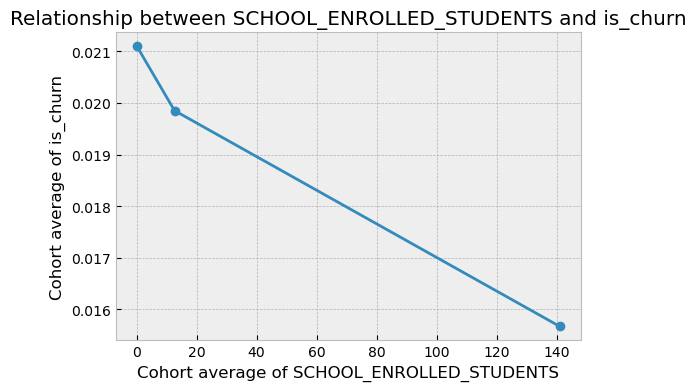

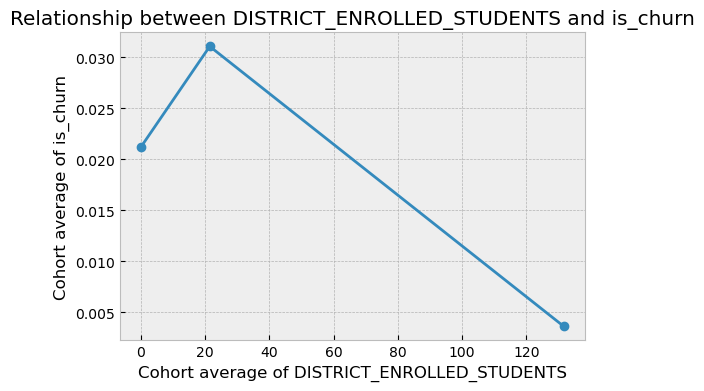

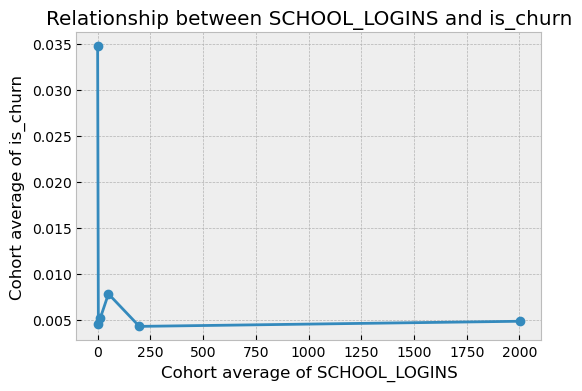

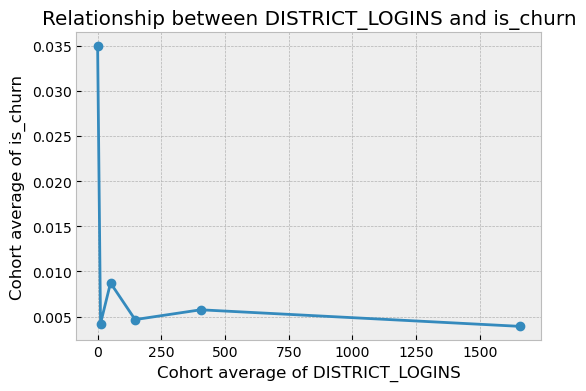

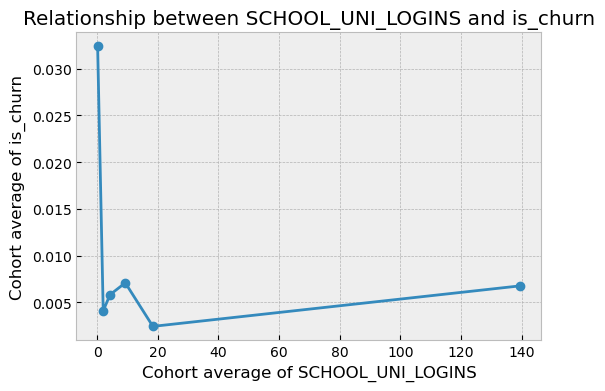

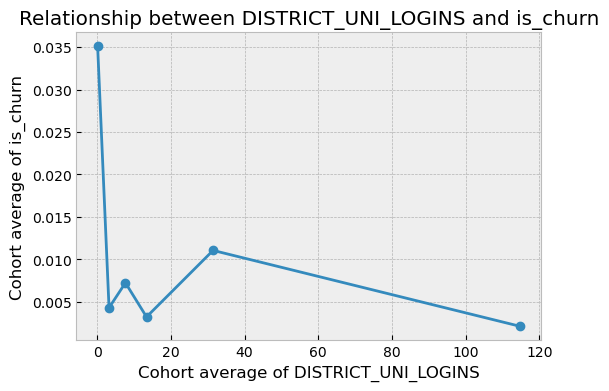

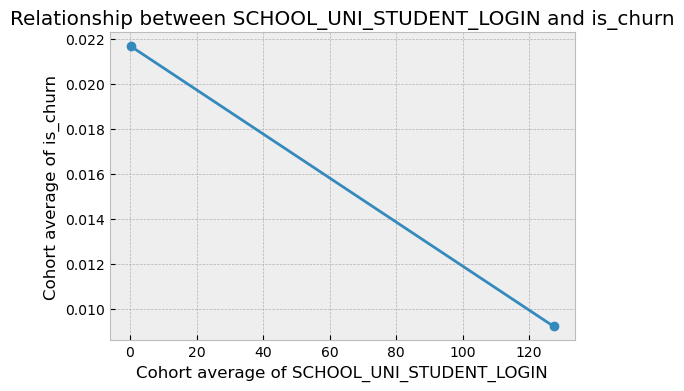

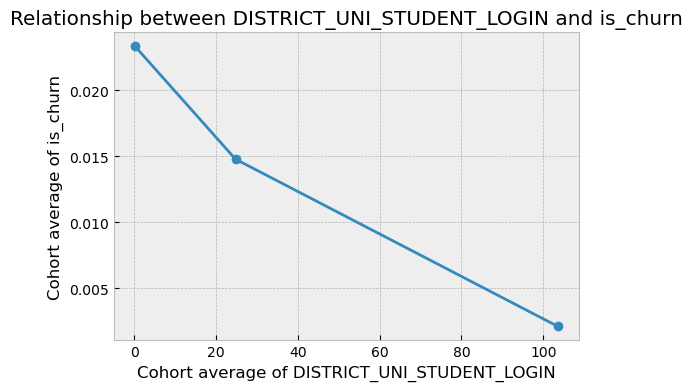

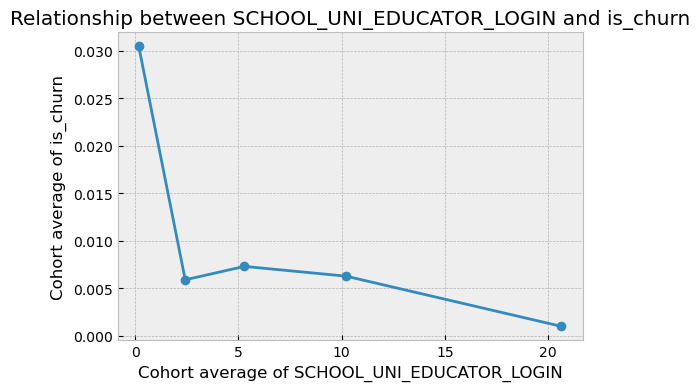

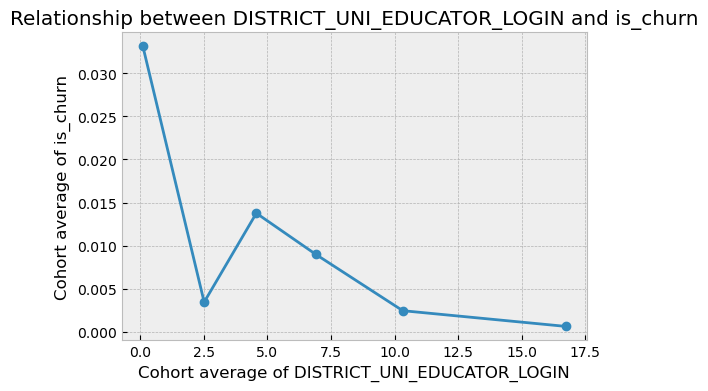

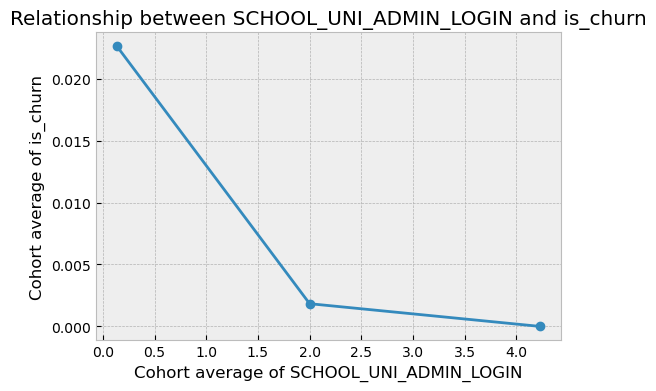

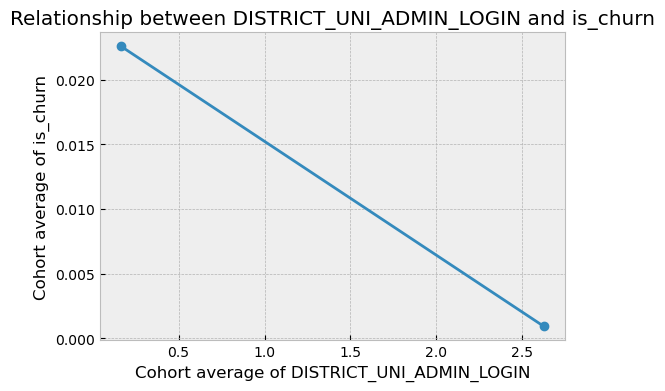

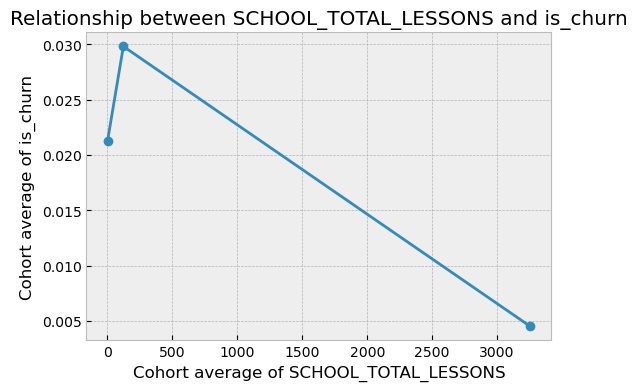

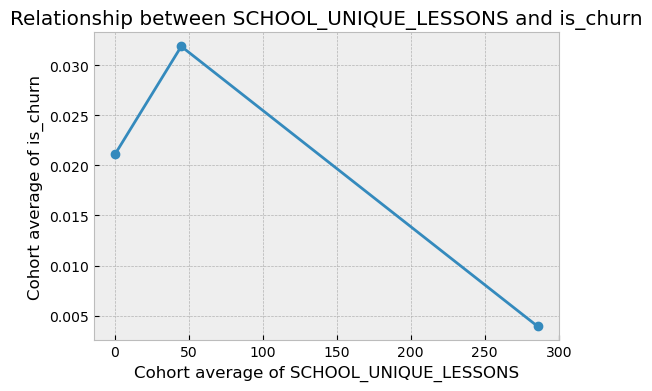

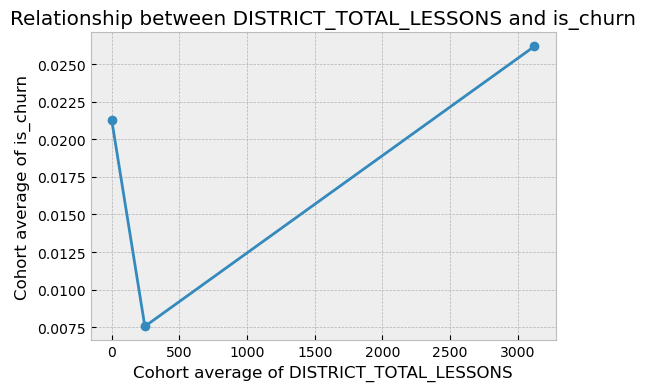

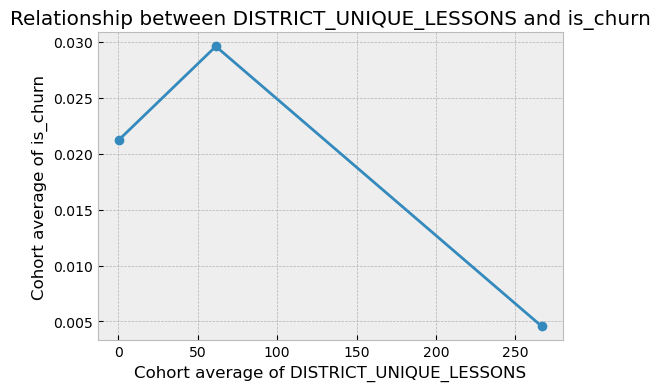

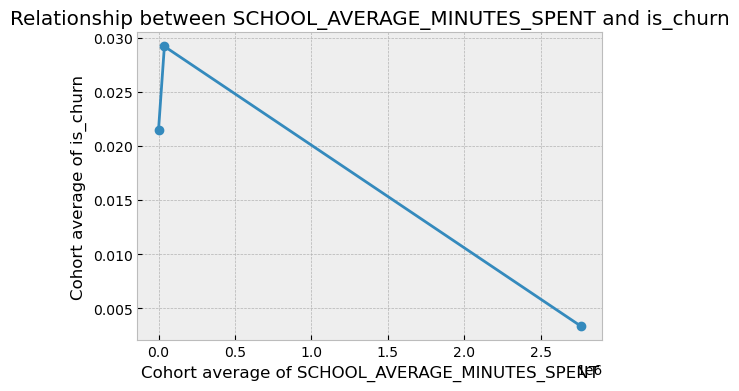

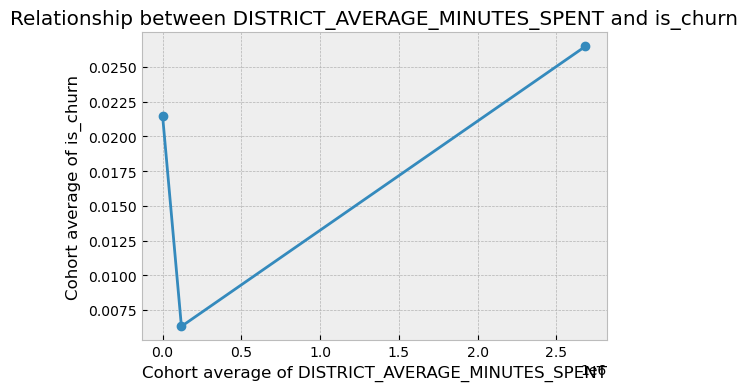

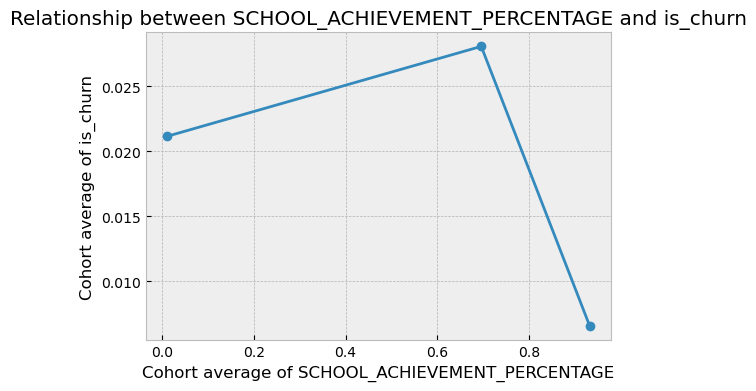

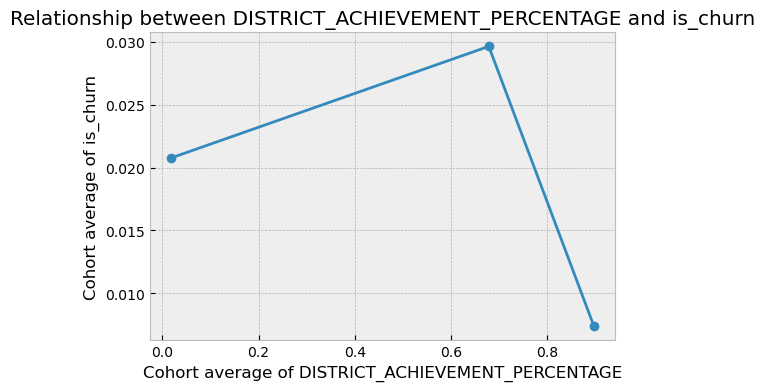

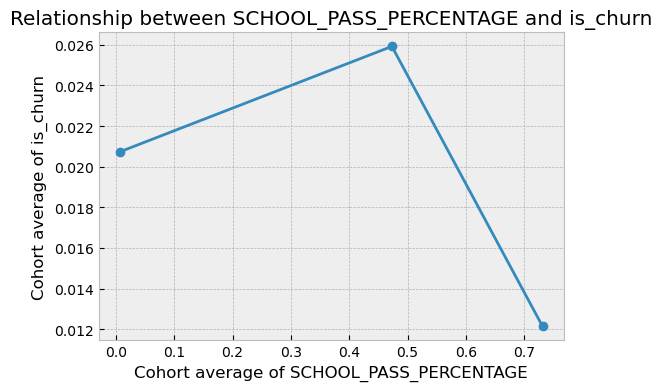

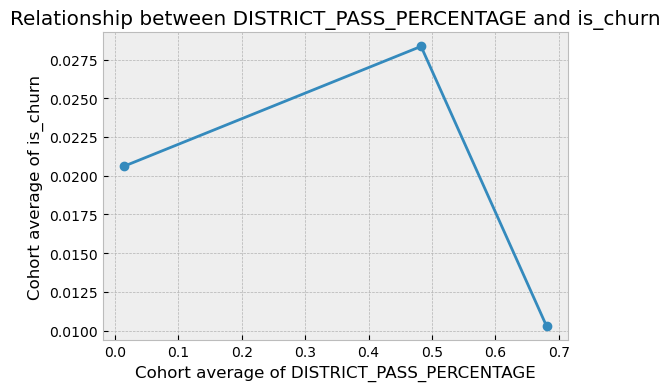

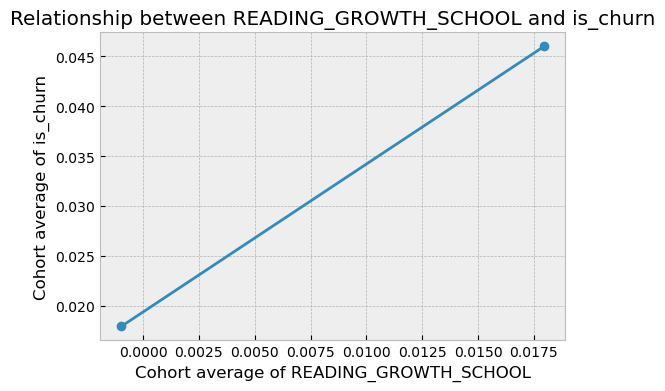

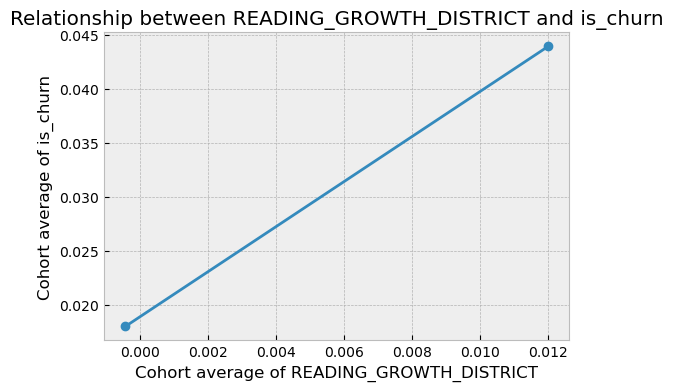

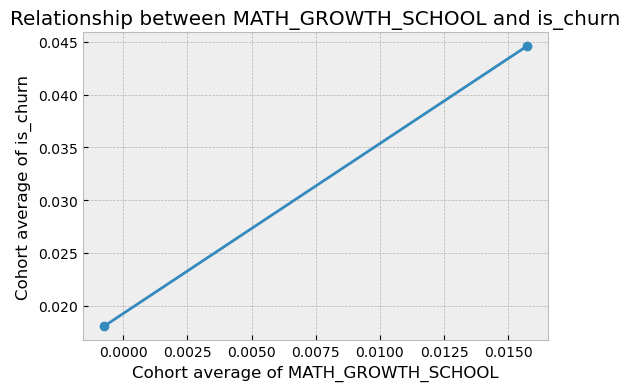

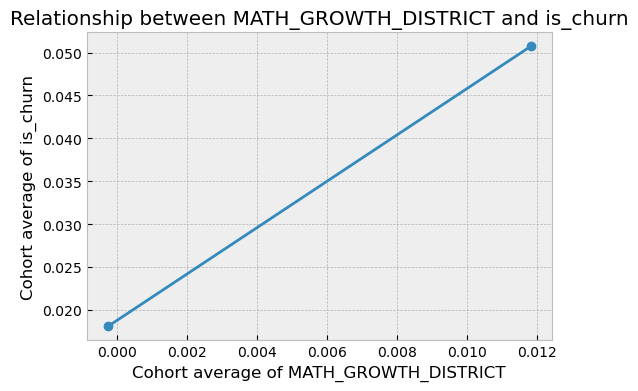

In [19]:
def cohort_plot(sourcedf, xmetric_name, ymetric_name, ncohort = 10, min_threshold = 5):
    # Cohorts are formed against xmetric and then means of each cohort is plotted for x and y metrics
    if len(sourcedf[xmetric_name].unique()) < min_threshold:
        cohort_xmeans = list(sourcedf[xmetric_name].unique())
        cohort_ymeans = sourcedf.groupby(xmetric_name)[ymetric_name].mean()
        df_to_plot = pd.DataFrame({xmetric_name: cohort_xmeans, ymetric_name: cohort_ymeans.values})
    else:
        groups = pd.qcut(sourcedf[xmetric_name], q=ncohort, duplicates = 'drop')
        cohort_xmeans = sourcedf.groupby(groups, observed=True)[xmetric_name].mean()
        cohort_ymeans = sourcedf.groupby(groups, observed=True)[ymetric_name].mean()
        df_to_plot = pd.DataFrame({xmetric_name: cohort_xmeans.values, ymetric_name: cohort_ymeans.values})
    
    plt.figure(figsize = (6,4))
    plt.plot(xmetric_name, ymetric_name, data = df_to_plot, marker = 'o', linewidth = 2)
    plt.xlabel('Cohort average of '+xmetric_name)
    plt.ylabel('Cohort average of '+ymetric_name)
    plt.grid(visible=True)
    plt.title("Relationship between "+xmetric_name+" and "+ymetric_name)


exclude_ = ['object'] # data type to exclude from the analysis
cols_ = []
for i in range(0, len(churn_metrics.dtypes), 1):
    if (str(churn_metrics.dtypes.iloc[i]) not in exclude_) & (churn_metrics.columns[i] != 'is_churn'):
        cols_.append(churn_metrics.columns[i])

for col in cols_:
    cohort_plot(churn_metrics, col, 'is_churn', 10, 5)

## DATA SPLIT

In [20]:
from sklearn.model_selection import train_test_split
churn_metrics['beginning_of_schoolyear'] = churn_metrics['SCHOOL_YEAR'].str.extract(r'(\d{4})').astype(int)

churn_metrics.sort_values(by = 'beginning_of_schoolyear', ascending = True, inplace = True)
churn_metrics.reset_index(inplace = True, drop = True)
churn_metrics.drop('beginning_of_schoolyear', axis=1, inplace = True)

# Prepare features and target labels
X = np.array(churn_metrics.drop(['SCHOOL_YEAR', 'is_churn'], axis=1))
y = np.array(churn_metrics['is_churn'])

# Prepare dataset and split it into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Time series split
tscv = TimeSeriesSplit(n_splits = 3)

## LOGISTIC REGRESSION

In [21]:
# Hyperparam selection
base_model = LogisticRegression(solver = 'liblinear')
test_par = {'C': [.005, .01, .04, .08, .16, .32, .64, .75, .95],
            'penalty' : ['l1','l2']          
           }
LR_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv = tscv, verbose = 1, n_jobs = -1)
LR_gsearch.fit(X_train,y_train)
LR_result_df = pd.DataFrame(LR_gsearch.cv_results_)

print(LR_gsearch.best_score_)
print(LR_gsearch.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/

0.7807254126114049
{'C': 0.32, 'penalty': 'l1'}


## RANDOM FOREST

Fitting 3 folds for each of 30 candidates, totalling 90 fits
0.8434152628513614
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}


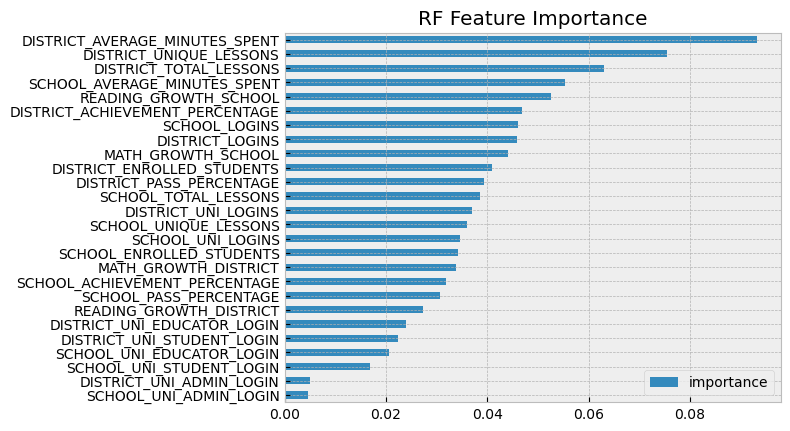

In [22]:
# Hyperparam selection
base_model = RandomForestClassifier(n_jobs = -1)
test_par = {'max_depth' : [2,5,10],
            'max_features': ['sqrt', 'log2'],
            'n_estimators': [5,10,100,500,1000]}
RF_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv=tscv, verbose=1, n_jobs=-1, refit=True)
RF_gsearch.fit(X_train,y_train)
RF_result_df = pd.DataFrame(RF_gsearch.cv_results_)

print(RF_gsearch.best_score_)
print(RF_gsearch.best_params_)

# Check feature importance
col_list = ['SCHOOL_ENROLLED_STUDENTS','DISTRICT_ENROLLED_STUDENTS','SCHOOL_LOGINS','DISTRICT_LOGINS','SCHOOL_UNI_LOGINS', 'DISTRICT_UNI_LOGINS', 'SCHOOL_UNI_STUDENT_LOGIN','DISTRICT_UNI_STUDENT_LOGIN', 'SCHOOL_UNI_EDUCATOR_LOGIN', 'DISTRICT_UNI_EDUCATOR_LOGIN', 'SCHOOL_UNI_ADMIN_LOGIN', 'DISTRICT_UNI_ADMIN_LOGIN', 'SCHOOL_TOTAL_LESSONS', 'SCHOOL_UNIQUE_LESSONS', 'DISTRICT_TOTAL_LESSONS', 'DISTRICT_UNIQUE_LESSONS', 'SCHOOL_AVERAGE_MINUTES_SPENT', 'DISTRICT_AVERAGE_MINUTES_SPENT', 'SCHOOL_ACHIEVEMENT_PERCENTAGE', 'DISTRICT_ACHIEVEMENT_PERCENTAGE', 'SCHOOL_PASS_PERCENTAGE', 'DISTRICT_PASS_PERCENTAGE', 'READING_GROWTH_SCHOOL', 'READING_GROWTH_DISTRICT', 'MATH_GROWTH_SCHOOL', 'MATH_GROWTH_DISTRICT']
X_feature = col_list
RF_feat = pd.DataFrame(data = RF_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance').plot(kind='barh', title = 'RF Feature Importance')
plt.show()

## XGBOOST

Fitting 3 folds for each of 300 candidates, totalling 900 fits
0.8452938453365252
{'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 0.05, 'n_estimators': 20}


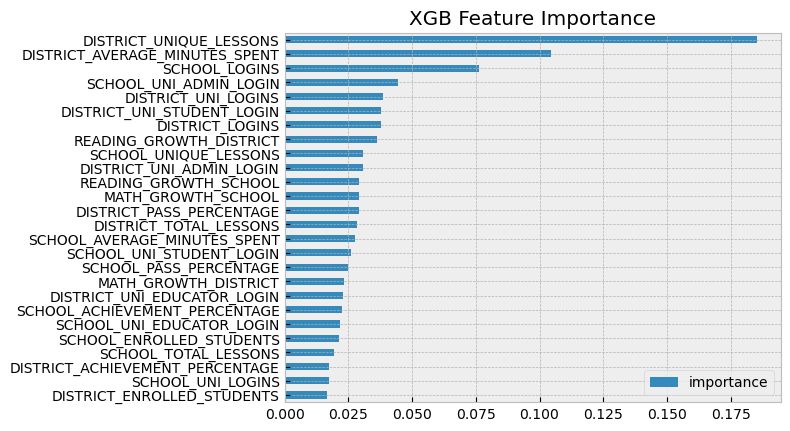

In [23]:
# Hyperparam selection
base_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs = -1, eval_metric = 'auc')
test_par = {'max_depth' : [2,10,20,25,40],
            'learning_rate': [.1,.2,.5],
            'n_estimators': [5,10,20,30,50],
            'min_child_weight': [.05,.15,.5,1]}
XGB_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv=tscv, verbose=1, n_jobs=-1, refit=True)
XGB_gsearch.fit(X_train,y_train)
XGB_result_df = pd.DataFrame(XGB_gsearch.cv_results_)

print(XGB_gsearch.best_score_)
print(XGB_gsearch.best_params_)

# Check feature importance
X_feature = col_list
RF_feat = pd.DataFrame(data = XGB_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance').plot(kind='barh', title = 'XGB Feature Importance')
plt.show()

## TEST SET

In [24]:
print(X_test.shape)
print(y_test.shape)

(6646, 26)
(6646,)


## MODEL PREDICTIONS

0.8536697643801452


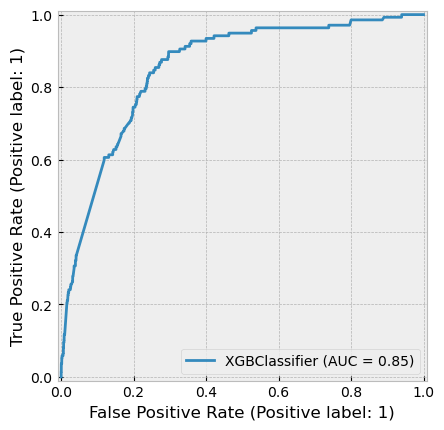

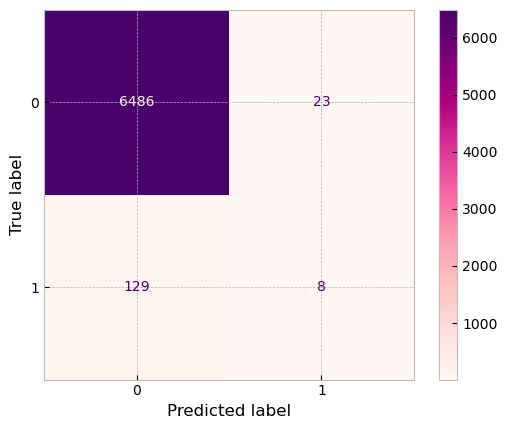

In [25]:
y_test_pred = XGB_gsearch.best_estimator_.predict_proba(X_test)[:,1]
print(metrics.roc_auc_score(y_test,y_test_pred))

metrics.RocCurveDisplay.from_estimator(XGB_gsearch.best_estimator_, X_test, y_test)
plt.show()

predicted_class = []
threshold = .5
for item in y_test_pred:
    if item >= threshold:
        predicted_class.append(1)
    else:
        predicted_class.append(0)
        
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted_class, labels=XGB_gsearch.best_estimator_.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=XGB_gsearch.best_estimator_.classes_)
cm_display.plot(cmap='RdPu')
# print(test_set.sort_values(by=['Predicted Churn Proba','is_churn'], ascending = False).head(5))


plt.style.use('bmh')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_Format', '{:,.2f}'.format)
np.set_printoptions(suppress=True)

## SHAP (SHapley Additive exPlanations)

In [26]:
import shap

Use the shap library to explain model predictions:

In [29]:
# Convert numpy arrays to pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=X_feature)
X_test_df = pd.DataFrame(X_test, columns=X_feature)
y_train_series = pd.Series(y_train, name='is_churn')

In [30]:
explainer = shap.TreeExplainer(XGB_gsearch.best_estimator_)
shap_values = explainer.shap_values(X_test)

Visualize Shapley values:

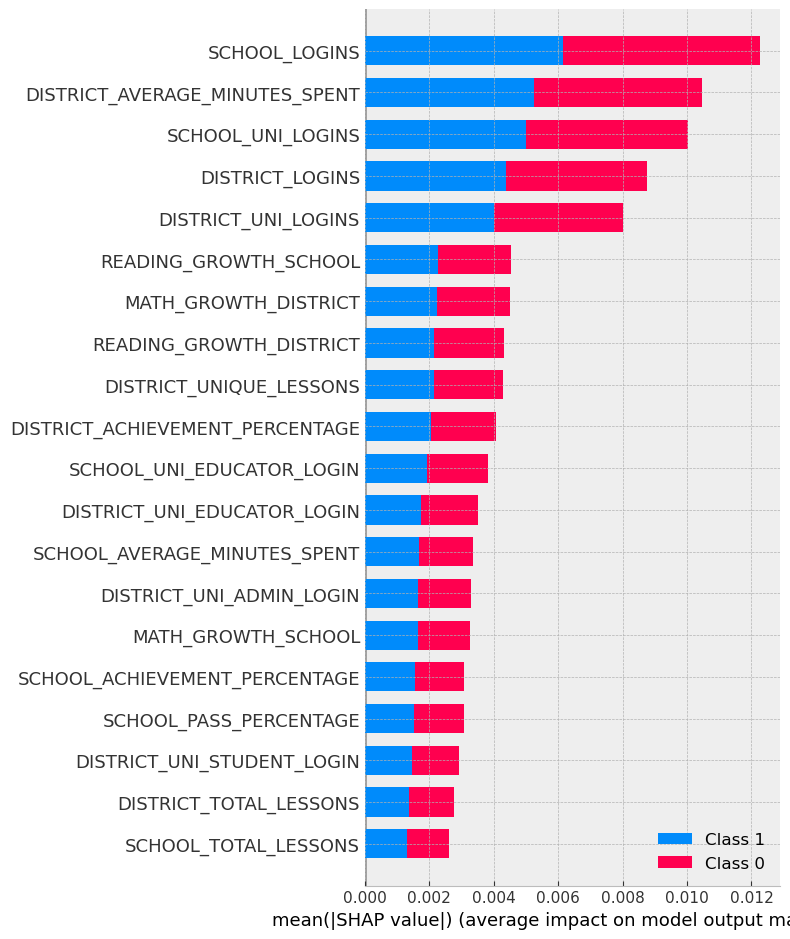

In [35]:
# Train your machine learning model
model = RandomForestClassifier()
model.fit(X_train_df, y_train_series)

# Use the shap library to explain model predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)

# Visualize Shapley values
shap.summary_plot(shap_values, X_test_df)

# Individual instance force plot
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_test_df.iloc[0, :])